In [1]:
import os
import csv
import json_lines
from collections import Counter

In [2]:
from keras import backend as K
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
from keras.regularizers import l2

Using TensorFlow backend.


In [3]:
from keras.utils import to_categorical

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [5]:
input_data_dir = '/home/aorus/workspaces/simge/sharedTask/output/Sentence/'
train_path = os.path.join(input_data_dir, 'train_filled.json')
dev_path = os.path.join(input_data_dir, 'dev_filled.json')
test_path = os.path.join(input_data_dir, 'test_filled.json')

In [6]:
test_path_china = os.path.join(input_data_dir, 'test_china_filled.json')

test_path = os.path.join(data_dir, 'test_filled.json')


# Data Preparation

### Train Data 

In [59]:
train_data = []
with json_lines.open(train_path) as reader:
    for obj in reader:
        train_data.append(obj)

In [60]:
train_data

[{'id': 100001,
  'label': 0,
  'last': False,
  'sent_num': 1,
  'sentence': 'Anantapur Lawyers to Revive Samaikya Agitation, to Lay Siege to Courts Today 27th January 2014 09:58 AM Renewing the Samikyandhra agitation, the lawyers of the district have decided to take on a series of protests starting with laying siege to courts on Monday.',
  'url': 'http://www.newindianexpress.com/states/andhra-pradesh/2014/jan/27/Anantapur-Lawyers-to-Revive-Samaikya-Agitation-to-Lay-Siege-to-Courts-Today-568575.html'},
 {'id': 100002,
  'label': 0,
  'last': False,
  'sent_num': 2,
  'sentence': '\nA meeting of lawyers was held in the town on Sunday in which the members of the Anantapur Bar Association in which various protests were planned',
  'url': 'http://www.newindianexpress.com/states/andhra-pradesh/2014/jan/27/Anantapur-Lawyers-to-Revive-Samaikya-Agitation-to-Lay-Siege-to-Courts-Today-568575.html'},
 {'id': 100003,
  'label': 0,
  'last': False,
  'sent_num': 3,
  'sentence': 'Speaking to repo

In [8]:
len(train_data), Counter([t['label'] for t in train_data])#, train_data[0]

(5885, Counter({0: 4897, 1: 988}))

In [61]:
X_tra = []
y_tra = []
sents=[]
labels=[]
for d_data in train_data:
    sents.append(d_data['sentence'].replace('\n', '').strip())  
    labels.append(d_data['label'])
    if d_data['last']:
        X_tra.append(sents)
        y_tra.append(labels)
        sents=[]
        labels=[]

In [70]:
len(y_tra[0])

13

In [10]:
del train_data

In [62]:
len(X_tra), len(y_tra)

(413, 413)

### Validation Data

In [71]:
dev_data = []
with json_lines.open(dev_path) as reader:
    for obj in reader:
        dev_data.append(obj)

In [13]:
len(dev_data), Counter([t['label'] for t in dev_data])#, dev_data[0]

(663, Counter({1: 138, 0: 525}))

In [ ]:
X_val = []
y_val = []
sents=[]
labels=[]
for d_data in dev_data:
    sents.append(d_data['sentence'].replace('\n', '').strip())
    labels.append(d_data['label'])
    if d_data['last']:
        X_tra.append(sents)
        y_tra.append(labels)
        sents=[]
        labels=[]

In [15]:
del dev_data

### Test Data

In [13]:
test_data = []
with json_lines.open(test_path) as reader:
    for obj in reader:
        test_data.append(obj)

In [14]:
X_test = []
for te_data in test_data:
    X_test.append(te_data['sentence'].replace('\n', '').strip())

In [21]:
test_data

[{'id': 19414071,
  'last': False,
  'sent_num': 1,
  'sentence': "Hospital encroaches private land 03rd October 2013 12:12 PM Around 30 people of Isufpur under Bhadrak police limits on Wednesday threatened to start a hunger strike before the Collector's office if encroachment on their land is not vacated.",
  'url': 'http://www.newindianexpress.com/states/odisha/2013/oct/03/Hospital-encroaches-private-land-522696.html'},
 {'id': 19414072,
  'last': False,
  'sent_num': 2,
  'sentence': '\nThey claimed that they were unable to use their land since 2009 as the authority of Unani hospital has encroached the approach road to the land',
  'url': 'http://www.newindianexpress.com/states/odisha/2013/oct/03/Hospital-encroaches-private-land-522696.html'},
 {'id': 19414073,
  'last': False,
  'sent_num': 3,
  'sentence': '"Despite having necessary permission from the authorities concerned, we cannot construct the house," said Sanghamitra Das, one of the residents of Isufpur.',
  'url': 'http://w

In [18]:
test_data_china = []
with json_lines.open(test_path_china) as reader:
    for obj in reader:
        test_data_china.append(obj)

In [21]:
X_test_china = []
for te_data in test_data_china:
    X_test_china.append(te_data['sentence'].replace('\n', '').strip())

In [22]:
X_test=np.array(X_test)
X_test_china= np.array(X_test_china)

## ONE HOT ENCODING

In [23]:
y_tra = to_categorical(y_tra)

In [24]:
y_val = to_categorical(y_val)

In [25]:
y_val

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [26]:
X_tra=np.array(X_tra)

In [27]:
X_val=np.array(X_val)

In [28]:
type(X_tra)

numpy.ndarray

In [29]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

In [30]:
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [31]:
input_text = Input(shape=(1,), dtype="string")
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
dense = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(embedding)
pred = Dense(2, activation='sigmoid')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

W0526 21:12:22.344075 139932537798784 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0526 21:12:22.346879 139932537798784 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0526 21:12:22.621595 139932537798784 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0526 21:12:22.638682 139932537798784 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/optimizers.py:790: T

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total params: 131,458
Trainable params: 131,458
Non-trainable params: 0
_________________________________________________________________


In [40]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(X_tra, y_tra, epochs=5, batch_size=32, validation_data=( X_val, y_val))
    model.save_weights('./Model/elmo-shared-task-model.h5')

W0523 15:17:34.679251 139639651467392 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 5885 samples, validate on 663 samples
Epoch 1/5
5885/5885 [==============================] - 39s 7ms/step - loss: 0.4518 - acc: 0.8610 - val_loss: 0.3962 - val_acc: 0.8688
Epoch 2/5
5885/5885 [==============================] - 33s 6ms/step - loss: 0.3642 - acc: 0.8733 - val_loss: 0.3596 - val_acc: 0.8695
Epoch 3/5
5885/5885 [==============================] - 33s 6ms/step - loss: 0.3315 - acc: 0.8809 - val_loss: 0.3588 - val_acc: 0.8718
Epoch 4/5
5885/5885 [==============================] - 33s 6ms/step - loss: 0.3105 - acc: 0.8881 - val_loss: 0.3412 - val_acc: 0.8725
Epoch 5/5
5885/5885 [==============================] - 33s 6ms/step - loss: 0.3017 - acc: 0.8887 - val_loss: 0.4296 - val_acc: 0.8560


In [43]:
hist = pd.DataFrame(history.history)

W0523 16:25:39.892519 139639651467392 legend.py:1282] No handles with labels found to put in legend.


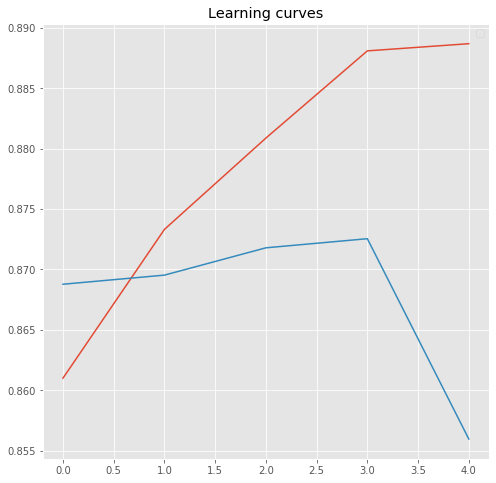

In [44]:
plt.figure(figsize=(8, 8))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.title("Learning curves")
plt.legend()
plt.show()

In [34]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./Model/elmo-shared-task-model.h5')  
    predicts_test = model.predict(X_test, batch_size=32)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f43f1941780>>
Traceback (most recent call last):
  File "/home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1471, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


In [35]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./Model/elmo-shared-task-model.h5')  
    predicts_china_test = model.predict(X_test_china, batch_size=32)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f43f1941128>>
Traceback (most recent call last):
  File "/home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1471, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


In [36]:
np.argmax(predicts_test, axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [55]:
model_preds_2 = np.argmax(predicts_china_test, axis=1)

In [52]:
y_true_1 = []
f = open('Preds/task2_test.solution', 'r')
for l in f.readlines():
    y_true_1.append(int(l.split('\t')[1].strip()))
    
f.close()

In [56]:
y_true_2 = []
f = open('Preds/china_test_task2.solution', 'r')
for l in f.readlines():
    y_true_2.append(int(l.split('\t')[1].strip()))
    
f.close()

In [54]:
from sklearn.metrics import f1_score
f1_score(y_true_1,model_preds_1, average='macro')

0.7173358469854073

In [58]:
from sklearn.metrics import f1_score
f1_score(y_true_2,model_preds_2, average='macro')

0.6206280393887476